In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [5]:
import os

input_path = '../../input/uci_thyroid'

In [254]:
col_names = [
        'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
        'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
        'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
        'psych', 'TSH', 'T3', 'TT4', 'T4U', 
        'FTI', 'class'
    ]
df = [
    pd.read_csv(
        f'{input_path}/ann-{tag}.data', header=None, names=col_names,
        delim_whitespace=True
    )
    for tag in ['train', 'test']
]
df = pd.concat([
    pd.concat(df, axis=0, ignore_index=True), 
    pd.Series([0]*len(df[0]) + [1]*len(df[1]), name='test')
], axis=1)

In [255]:
print( df.duplicated().value_counts() )
df = df.drop_duplicates()
df.shape
df_train, df_test = df[df['test'] == 0], df[df['test'] == 1]

False    7129
True       71
dtype: int64


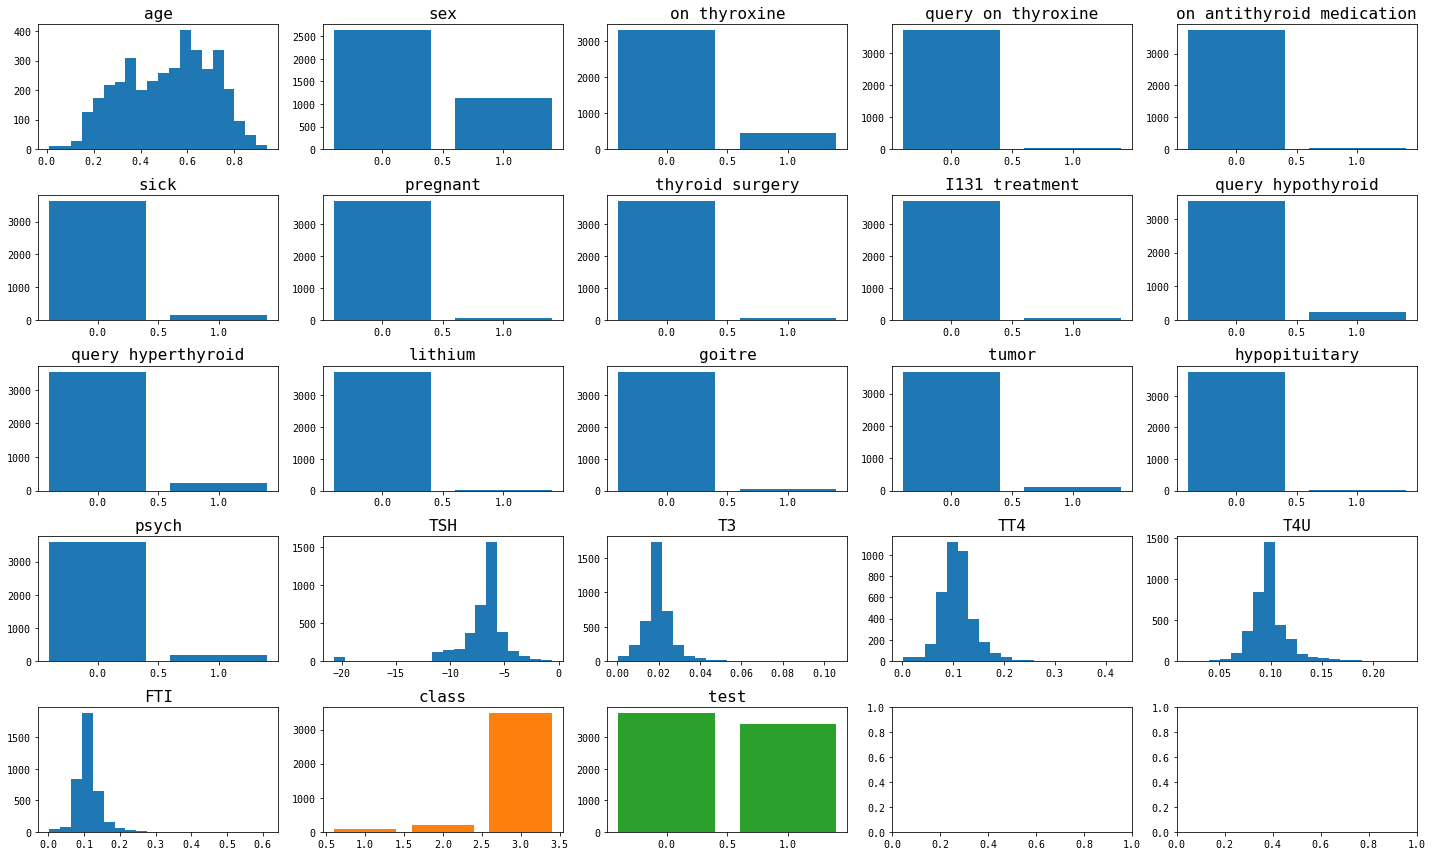

In [216]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 12))
axs = axs.ravel()
for num, name in enumerate(df.columns):
    ax = axs[num]

    if name in ['TSH']:
        ax.hist(np.log(1e-9+df.loc[df['test'] == 0, name]), bins=20)
    elif name in ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
        ax.hist(df.loc[df['test'] == 0, name], bins=20)
    elif name == 'class':
        ax.bar(
            np.sort(df.loc[df['test'] == 0, name].unique()), df.loc[df['test'] == 0, name].value_counts().sort_index(),
            color='C1'
            )
    elif name == 'test':
        ax.bar(
            np.sort(df[name].unique()), df[name].value_counts().sort_index(),
            color='C3'
            )
    else:
        ax.bar(np.sort(df.loc[df['test'] == 0, name].unique()), df.loc[df['test'] == 0, name].value_counts().sort_index())
    ax.set_title(name, fontsize=16)

    # if name in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    #     ax.set_yscale('log')

plt.tight_layout()
plt.show(); plt.close()

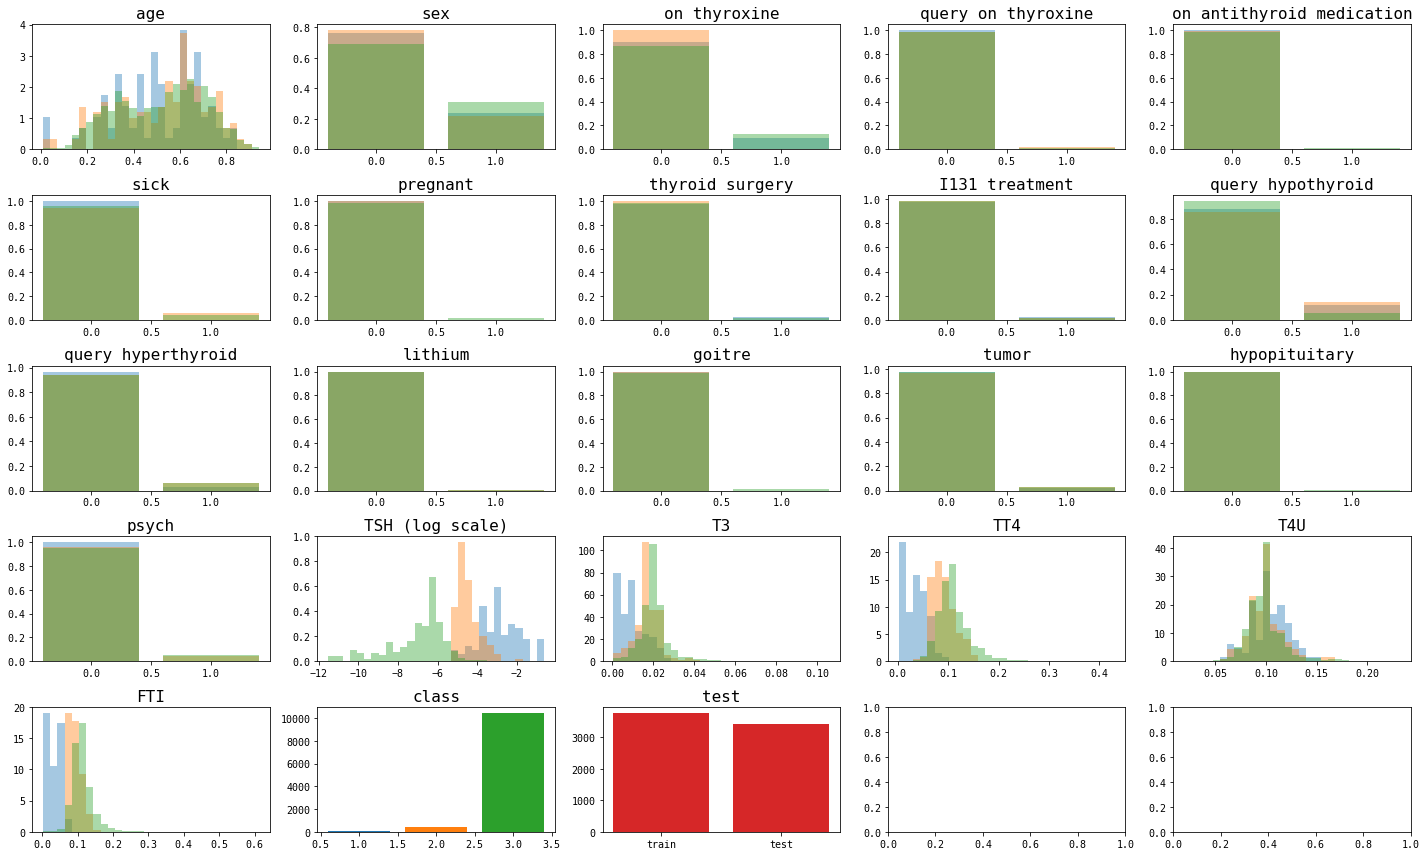

In [235]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 12))
axs = axs.ravel()
for num, name in enumerate(df.columns):
    ax = axs[num]
    title = name
    ser_all = df.loc[df['test'] == 0, name]
    if name in ['TSH']:
        ser_all = np.log(1e-5+ser_all)
        title = f'{name} (log scale)'
    _, bins = np.histogram(ser_all, bins=30)
    alpha = 0.4
    for j in range(1, 1+3):
        ser = ser_all[df.loc[df['test'] == 0, 'class'] == j]
        if name in ['TSH', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
            ax.hist(ser, bins=bins, density=True, color=f'C{j-1}', alpha=alpha)
        elif name == 'class':
            ax.bar([j], [ser.sum()], color=f'C{j-1}')
        elif name == 'test':
            continue
        else:
            ax.bar(np.sort(ser.unique()), ser.value_counts(normalize=True).sort_index(), color=f'C{j-1}', alpha=alpha)
    if name == 'test':
        ax.bar(['train', 'test'], [(df['test'] == 0).sum(), (df['test'] == 1).sum()], color='C3')

    ax.set_title(title, fontsize=16)

plt.tight_layout()
plt.show(); plt.close()

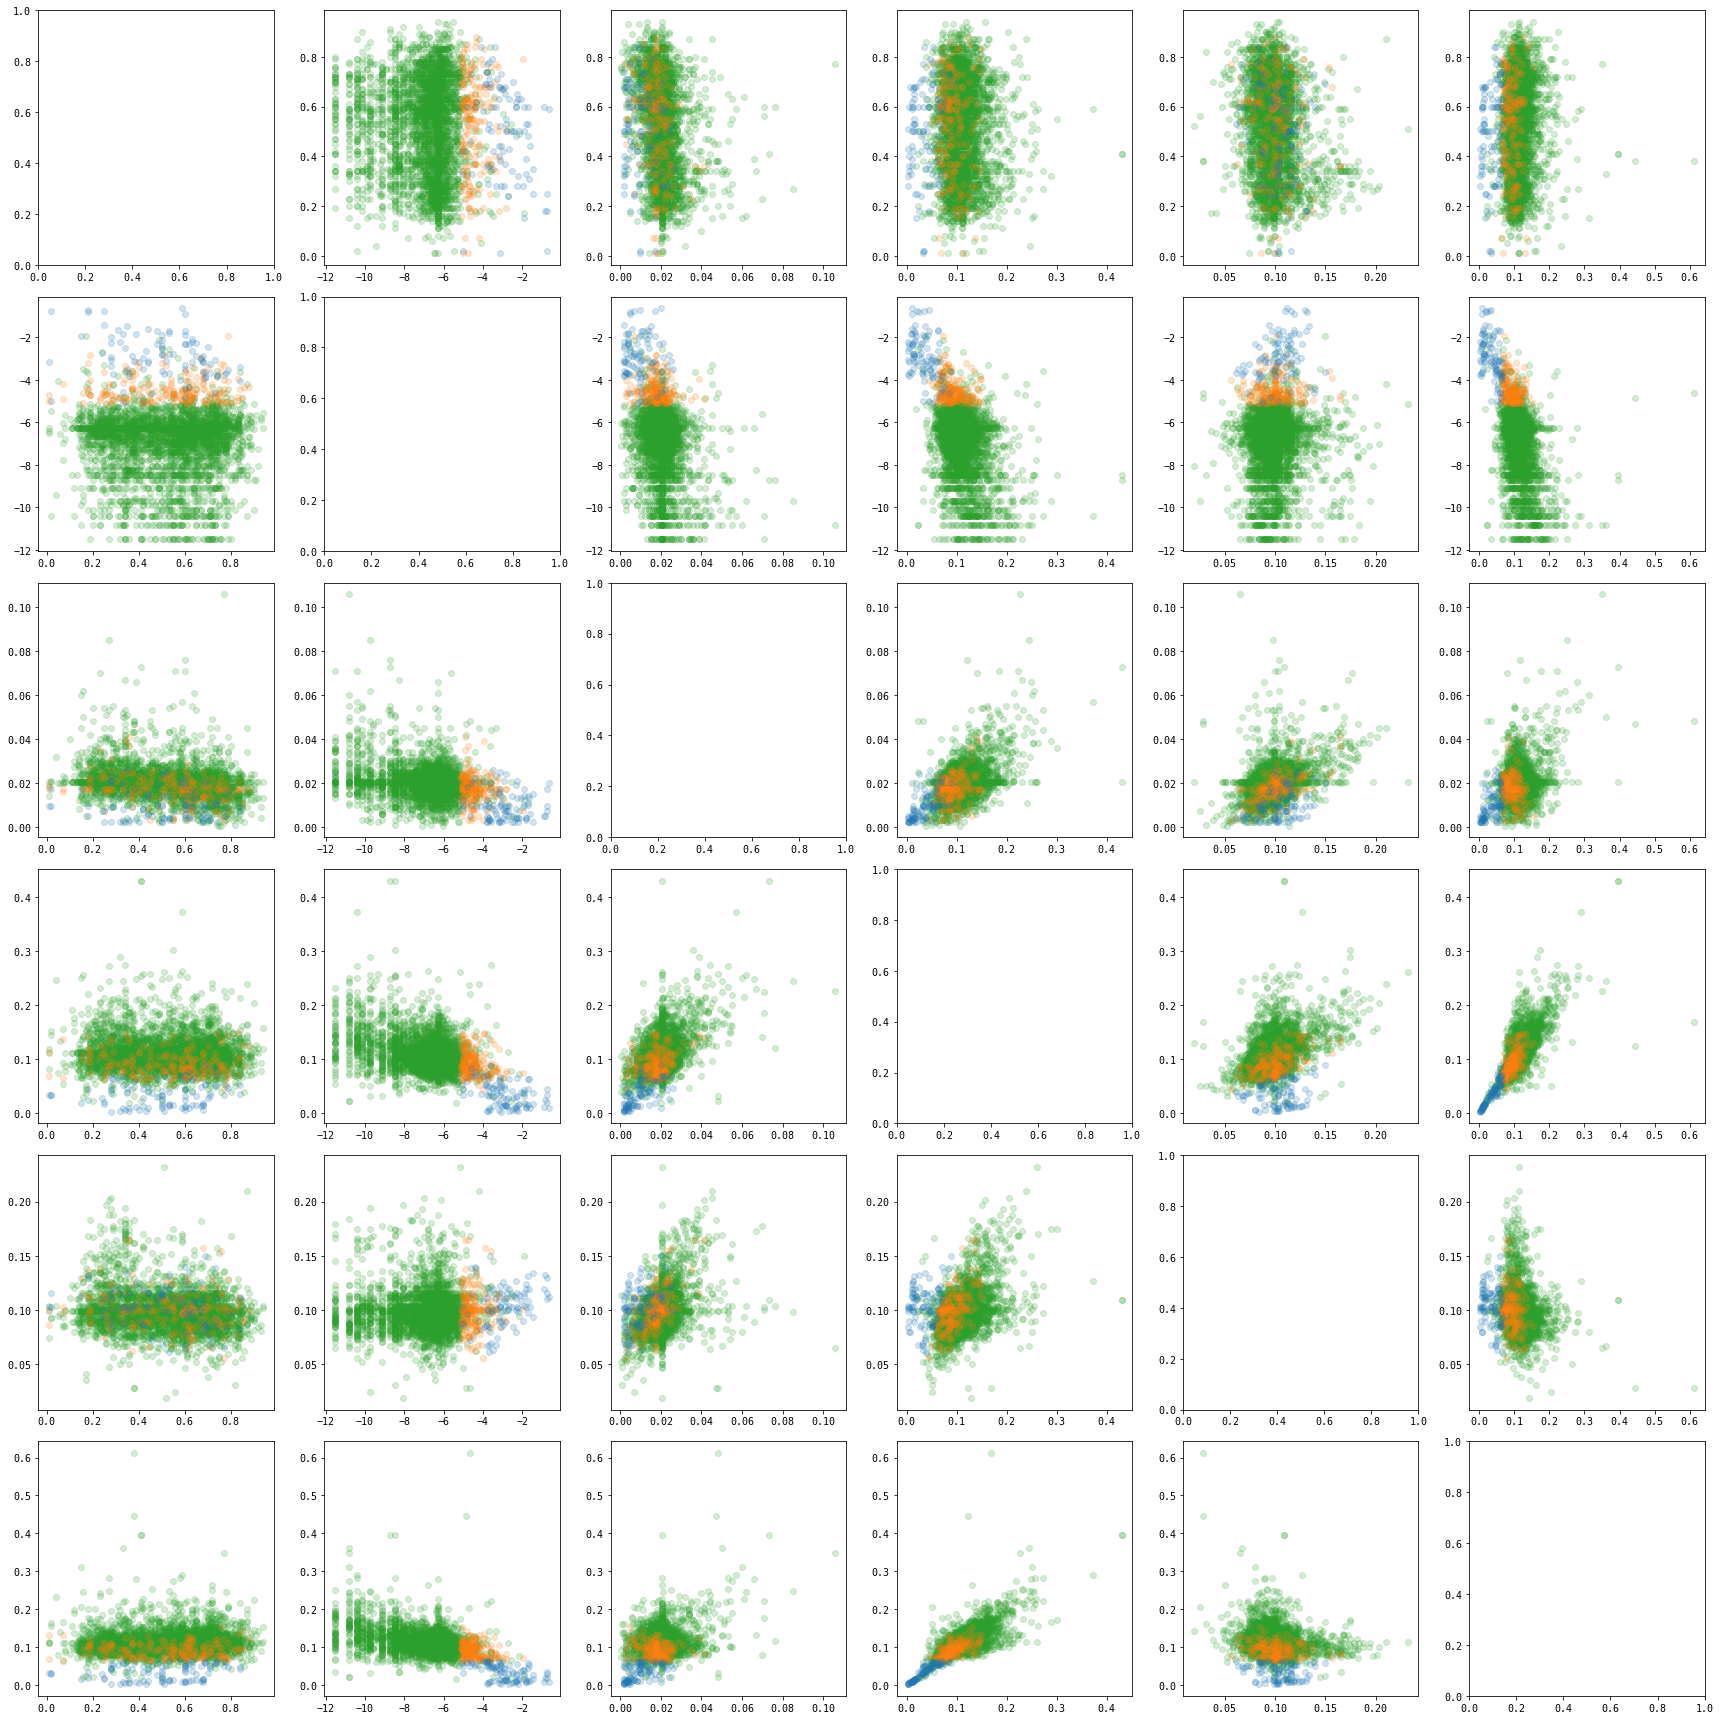

In [277]:
import itertools

vecs = [df_train[name] for name in ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']]
vecs[1] = np.log(1e-5+vecs[1])

fig, axs = plt.subplots(nrows=len(vecs), ncols=len(vecs), figsize=(24, 24))
for i, j, k in itertools.product(range(len(vecs)), range(len(vecs)), range(3, 0, -1)):
    ax = axs[j, i]
    mask = df_train['class'] == k
    i == j or ax.scatter(vecs[i][mask], vecs[j][mask], color=f'C{k-1}', alpha=0.2)

plt.tight_layout(); plt.show(); plt.close()

In [249]:
df['hypopituitary'].value_counts()

0    7128
1       1
Name: hypopituitary, dtype: int64

In [251]:
df[['sex', 'pregnant']].drop_duplicates()

,sex,pregnant
0,0,0
3,1,0
52,0,1


In [256]:
df_test['class'].value_counts(normalize=True)

3    0.926901
2    0.051754
1    0.021345
Name: class, dtype: float64

In [284]:
from sklearn.decomposition import PCA

conti_vars = np.stack(vecs, axis=1)
conti_vars /= np.std(conti_vars, axis=0)

pca = PCA().fit(conti_vars)
pca.explained_variance_ratio_

array([0.41559128, 0.24390336, 0.14796756, 0.10461608, 0.08238409,
       0.00553762])